In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import time

# Dataset Class
class PFM_TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, history_len=8, prediction_len=12):
        self.data = self.load_data(file_path)
        self.history_len = history_len
        self.prediction_len = prediction_len
        # Create a list of valid frame indices that have enough history and future data
        self.valid_frames = self._get_valid_frames()

    def load_data(self, file_path):
        data = {}
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                if len(parts) == 4:  # Ensure valid line
                    frame, agent, x, y = map(float, parts)
                    frame, agent = int(frame/10), int(agent)
                    if frame not in data:
                        data[frame] = {}
                    data[frame][agent] = torch.tensor([x, y], dtype=torch.float32)
        return data

    def _get_valid_frames(self):
        """Get frames that have sufficient history and future data"""
        all_frames = sorted(self.data.keys())
        valid_frames = []

        for frame in all_frames:
            # Check if we have enough history and future frames
            history_start = frame - self.history_len + 1
            future_end = frame + self.prediction_len

            # Ensure we have data for the required time range
            if history_start >= min(all_frames) and future_end <= max(all_frames):
                valid_frames.append(frame)

        return valid_frames

    def __len__(self):
        return len(self.valid_frames)

    def __getitem__(self, idx):
        frame = self.valid_frames[idx]

        # Get all agents present at this frame
        if frame not in self.data:
            # Return empty tensors if no data
            return (torch.zeros(0, self.history_len, 2),
                   torch.zeros(0, self.prediction_len, 2),
                   torch.zeros(0, 0, 2),
                   torch.zeros(0, 2))

        agents = list(self.data[frame].keys())
        num_agents = len(agents)

        if num_agents == 0:
            return (torch.zeros(0, self.history_len, 2),
                   torch.zeros(0, self.prediction_len, 2),
                   torch.zeros(0, 0, 2),
                   torch.zeros(0, 2))

        history = torch.zeros(num_agents, self.history_len, 2)
        future = torch.zeros(num_agents, self.prediction_len, 2)
        goals = torch.zeros(num_agents, 2)

        for i, agent in enumerate(agents):
            # Fill history (going backwards from current frame)
            for t in range(self.history_len):
                hist_frame = frame - (self.history_len - 1 - t)  # Fixed indexing
                if hist_frame in self.data and agent in self.data[hist_frame]:
                    history[i, t] = self.data[hist_frame][agent]
                # If no data available, position remains zero (padding)

            # Fill future (going forwards from next frame)
            for t in range(self.prediction_len):
                fut_frame = frame + t + 1  # Start from next frame
                if fut_frame in self.data and agent in self.data[fut_frame]:
                    future[i, t] = self.data[fut_frame][agent]
                # If no data available, position remains zero (padding)

            # Extract goal from the last timestep of future trajectory
            # Find the last non-zero position in future, or use the last timestep
            non_zero_mask = torch.any(future[i] != 0, dim=1)
            if non_zero_mask.any():
                last_valid_idx = torch.where(non_zero_mask)[0][-1]
                goals[i] = future[i, last_valid_idx]
            else:
                # If no future data, use current position as goal
                goals[i] = self.data[frame][agent]

        # Collect neighbors for each agent at the current frame
        neighbors_list = []
        for i, agent in enumerate(agents):
            # Get positions of all other agents at the current frame
            agent_neighbors = []
            for other_agent in self.data[frame]:
                if other_agent != agent:
                    agent_neighbors.append(self.data[frame][other_agent])

            if agent_neighbors:
                neighbors_tensor = torch.stack(agent_neighbors)
            else:
                # If no neighbors, create a dummy neighbor at origin
                neighbors_tensor = torch.zeros(1, 2)

            neighbors_list.append(neighbors_tensor)

        # Pad neighbors to have the same number for all agents
        if neighbors_list:
            max_neighbors = max(n.shape[0] for n in neighbors_list)
            padded_neighbors = torch.zeros(num_agents, max_neighbors, 2)

            for i, neighbor_tensor in enumerate(neighbors_list):
                padded_neighbors[i, :neighbor_tensor.shape[0]] = neighbor_tensor

            neighbors = padded_neighbors
        else:
            neighbors = torch.zeros(num_agents, 1, 2)

        return history, future, neighbors, goals

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    """Collate function for batches that include goal"""
    max_agents = max(sample[0].shape[0] for sample in batch)
    # history
    max_neighbors = max(sample[2].shape[1] for sample in batch)  # neighbors
    hist_len = batch[0][0].shape[1]
    fut_len = batch[0][1].shape[1]

    padded_histories = []
    padded_futures = []
    padded_neighbors = []
    padded_goals = []

    for sample in batch:
        history, future, neighbors, goal = sample
        A, H, D = history.shape
        N = neighbors.shape[1]

        padded_hist = torch.zeros(max_agents, hist_len, D)
        padded_fut = torch.zeros(max_agents, fut_len, D)
        padded_neigh = torch.zeros(max_agents, max_neighbors, D)
        padded_goal = torch.zeros(max_agents, D)

        padded_hist[:A] = history
        padded_fut[:A] = future
        padded_neigh[:A, :N] = neighbors
        padded_goal[:A] = goal

        padded_histories.append(padded_hist)
        padded_futures.append(padded_fut)
        padded_neighbors.append(padded_neigh)
        padded_goals.append(padded_goal)

    return (
        torch.stack(padded_histories),   # [B, A, hist_len, D]
        torch.stack(padded_futures),     # [B, A, fut_len, D]
        torch.stack(padded_neighbors),   # [B, A, max_neighbors, D]
        torch.stack(padded_goals)        # [B, A, D]
    )

# FIXED: Added goals to test data (4th element in each tuple)
test_batch = [
    (torch.rand(3, 8, 2), torch.rand(3, 12, 2), torch.rand(3, 5, 2), torch.rand(3, 2)),  # 3 agents with goals
    (torch.rand(2, 8, 2), torch.rand(2, 12, 2), torch.rand(2, 3, 2), torch.rand(2, 2)),  # 2 agents with goals
    (torch.rand(4, 8, 2), torch.rand(4, 12, 2), torch.rand(4, 6, 2), torch.rand(4, 2))   # 4 agents with goals
]

# Now this should work correctly
hist, fut, neigh, goals = collate_fn(test_batch)  # Note: also need to unpack goals here
print(f"History shape: {hist.shape}")     # Will be [3, 4, 8, 2]
print(f"Future shape: {fut.shape}")       # Will be [3, 4, 12, 2]
print(f"Neighbors shape: {neigh.shape}")  # Will be [3, 4, 6, 2]
print(f"Goals shape: {goals.shape}")      # Will be [3, 4, 2]

History shape: torch.Size([3, 4, 8, 2])
Future shape: torch.Size([3, 4, 12, 2])
Neighbors shape: torch.Size([3, 4, 6, 2])
Goals shape: torch.Size([3, 4, 2])


## Dataset speed calculation

In [ ]:
def compute_dataset_average_speed(file_path):
    """
    Compute average speed for an entire dataset file: frame, agent, x, y
    """
    import numpy as np

    agent_positions = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, agent, x, y = line.strip().split(',')
            frame, agent = int(frame), int(agent)
            x, y = float(x), float(y)
            agent_positions.setdefault(agent, []).append((frame, x, y))

    speeds = []
    for traj in agent_positions.values():
        traj.sort(key=lambda p: p[0])  # sort by frame
        for i in range(1, len(traj)):
            _, x1, y1 = traj[i-1]
            _, x2, y2 = traj[i]
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            speeds.append(dist)

    return float(np.mean(speeds)) if speeds else 0.0

ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
import numpy as np

def compute_average_speed_from_file_ZARA(file_path, delimiter=None):
    """
    Compute average speed across all agents from trajectory data in file.

    Args:
        file_path (str): Path to the file containing data: frame agent x y
        delimiter (str or None): delimiter for np.loadtxt (default None detects spaces).
                                Use "," if your file is comma separated.

    Returns:
        float: average speed (units per frame step)
    """
    # Load dataset: shape (N,4) --> frame, agent, x, y
    data = np.loadtxt(file_path, delimiter=delimiter)

    # Sort by agent then by frame to ensure proper ordering
    data = data[np.lexsort((data[:,0], data[:,1]))]

    total_distance = 0.0
    total_transitions = 0

    # Process each agent separately
    for agent_id in np.unique(data[:,1]):
        agent_data = data[data[:,1] == agent_id]

        # Filter out zero positions (padded)
        mask = ~((agent_data[:,2] == 0) & (agent_data[:,3] == 0))
        agent_data = agent_data[mask]

        if len(agent_data) < 2:
            continue

        frames = agent_data[:,0]
        positions = agent_data[:, 2:4]

        # Calculate Euclidean distances between consecutive positions
        displacements = positions[1:] - positions[:-1]
        distances = np.linalg.norm(displacements, axis=1)

        # Calculate time differences (frame differences)
        delta_times = frames[1:] - frames[:-1]

        # Ignore zero or negative time intervals (avoid division issues)
        valid_mask = delta_times > 0

        total_distance += distances[valid_mask].sum()
        total_transitions += delta_times[valid_mask].sum()  # total time elapsed

    if total_transitions > 0:
        avg_speed = total_distance / total_transitions
    else:
        avg_speed = 0.0

    return avg_speed

file_path = "/content/crowds_zara02_test.txt"
average_speed = compute_average_speed_from_file_ZARA(file_path)
print(f"Average speed: {average_speed:.4f} units per frame")

Average speed: 0.0278 units per frame


## INTEGRATED PFM Model

In [ ]:
# Potential Field
class PotentialField(nn.Module):
    def __init__(self, goal, num_agents=64, k_init=1.0, repulsion_radius=0.5):
        super().__init__()
        self.register_buffer('goal', torch.tensor(goal, dtype=torch.float32))
        self.repulsion_radius = repulsion_radius

        # 3 coefficients are to be learned
        self.coeff_embedding = nn.Embedding(num_agents, 3)
        self.coeff_embedding.weight.data.fill_(k_init)

    def forward(self, pos, predicted, neighbors, goal, coeffs): #RK using input coeffts and goal
        """
        Compute the APF-based force vector for each agent.

        Parameters:
        - pos:       [B, A, 2]      - current agent positions
        - predicted: [B, A, 1, 2]   - predicted next positions (single step)
        - neighbors: [B, A, N, 2]   - neighboring agents' current positions
        - goal:      [B, A, 2]      - true goal positions (final ground-truth)
        - coeffs:    [B, A, 3]      - APF coefficients per agent (k_att1, k_att2, k_rep)

        Returns:
        - total_force: [B, A, 2]
        - coeffs:      [B, A, 3]
        """

        # Split coefficients
        k_att1 = coeffs[..., 0:1]  # for attractive force to goal
        k_att2 = coeffs[..., 1:2]  # for attractive force to predicted
        k_rep  = coeffs[..., 2:3]  # for repulsive force

        # --- Attractive Forces ---
        F_goal = k_att1 * (goal - pos)                    # [B, A, 2]
        F_pred = k_att2 * (predicted[:, :, 0, :] - pos)   # [B, A, 2]

        # --- Repulsive Forces ---
        diffs = pos.unsqueeze(2) - neighbors              # [B, A, N, 2]
        dists = torch.norm(diffs, dim=-1, keepdim=True) + 1e-6  # [B, A, N, 1]
        mask = (dists < self.repulsion_radius).float()    # Only repel nearby neighbors

        F_rep = (k_rep.unsqueeze(2) * diffs / dists.pow(2) * mask).sum(dim=2)  # [B, A, 2]

        # --- Total Force ---
        total_force = F_goal + F_pred + F_rep

        return total_force, coeffs



class IntegratedMTAPFMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, goal=(4.2, 4.2)):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_embed = nn.Linear(input_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.postprocess = nn.Linear(input_size, input_size)  # RK: extra dense layer after decoder output
        self.output = nn.Linear(hidden_size, input_size)
        self.pfm = PotentialField(goal=goal)

        # Speed constraint parameters
        self.target_avg_speed = 0.0278 # From your calculated average
        self.speed_tolerance = 0.15     # 15% tolerance
        self.min_speed = self.target_avg_speed * (1 - self.speed_tolerance)  # 0.2547
        self.max_speed = self.target_avg_speed * (1 + self.speed_tolerance)  # 0.3445

    def apply_speed_constraints(self, predictions, last_positions):
        """
        Apply speed constraints to predictions by clipping speeds to thresholds
        Args:
            predictions: [B, A, T, 2] predicted trajectories
            last_positions: [B, A, 2] last known positions (from history)
        Returns:
            constrained_predictions: [B, A, T, 2] speed-constrained predictions
        """
        B, A, T, D = predictions.shape
        constrained_preds = predictions.clone()

        # Start from the last known position
        current_pos = last_positions.clone()  # [B, A, 2]

        for t in range(T):
            # Calculate displacement from current position to predicted next position
            displacement = predictions[:, :, t] - current_pos  # [B, A, 2]

            # Calculate speed (distance) for this step
            speeds = torch.norm(displacement, dim=-1, keepdim=True)  # [B, A, 1]

            # Clip speeds to the allowed range
            # Don't clip zero speeds (padding), only clip actual movements
            non_zero_mask = speeds > 0
            clipped_speeds = torch.clamp(speeds, self.min_speed, self.max_speed)

            # Only apply clipping to non-zero speeds (preserve padding)
            final_speeds = torch.where(non_zero_mask, clipped_speeds, speeds)

            # Calculate new displacement with clipped speed
            # Keep the direction, but adjust the magnitude
            direction = displacement / (speeds + 1e-8)  # Unit direction vector
            clipped_displacement = direction * final_speeds

            # Update constrained prediction for this timestep
            constrained_preds[:, :, t] = current_pos + clipped_displacement

            # Update current position for next iteration
            current_pos = constrained_preds[:, :, t].clone()

        return constrained_preds

    def forward(self, history, neighbors, goal):  # RK: add goal as input here
        B, A, H, D = history.shape
        device = history.device

        agent_ids = torch.arange(A).repeat(B, 1).to(device)  # [B, A]

        # LSTM encoding
        hist_flat = history.reshape(B * A, H, D)
        hist_embedded = self.input_embed(hist_flat)
        _, (h_n, c_n) = self.encoder(hist_embedded)

        # LSTM decoding
        pred_flat = torch.zeros(B * A, 12, D, device=device)
        h_n = h_n[-1].unsqueeze(0).repeat(self.num_layers, 1, 1)

        for t in range(12):
            current_pred = pred_flat[:, t:t+1].clone()
            pred_embedded = self.input_embed(current_pred)
            out, (h_n, c_n) = self.decoder(pred_embedded, (h_n, c_n))
            step_output = self.output(out.squeeze(1))            # [B*A, D]
            pred_flat[:, t] = self.postprocess(step_output)       # RK: apply additional dense layer here

        predictions = pred_flat.view(B, A, 12, D)

        # PFM adjustment
        adjusted_preds = torch.zeros_like(predictions)
        current_pos = history[:, :, -1, :].clone()  # Initial position
        coeff_list = []

        coeffs = self.pfm.coeff_embedding(agent_ids)  # RK: get APF coefficients from embedding

        for t in range(12):
            pred_slice = predictions[:, :, t:t+1].clone()
            forces, coeff_step = self.pfm(  # RK: pass APF coefficients and goal
                current_pos, pred_slice, neighbors.clone(), goal, coeffs
            )

            if t == 0:
                adjusted_preds[:, :, t] = current_pos + forces
            else:
                adjusted_preds[:, :, t] = adjusted_preds[:, :, t - 1] + forces

            coeff_list.append(coeff_step)

            current_pos = adjusted_preds[:, :, t].clone()  # RK: update current_pos here

        # Apply speed constraints after PFM adjustments
        last_known_pos = history[:, :, -1, :]
        constrained_preds = self.apply_speed_constraints(adjusted_preds, last_known_pos)

        coeff_stack = torch.stack(coeff_list, dim=0)  # [12, B, A, 3]
        coeff_mean = coeff_stack.mean()
        coeff_var = coeff_stack.var(unbiased=False)

        return constrained_preds, coeff_mean, coeff_var

## MTA only model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint


class DeepLSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dt=0.1,
                 target_avg_speed=0.0278, speed_tolerance=0.15):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dt = dt

        self.input_embed = nn.Linear(input_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, input_size)
        self.postprocess = nn.Linear(input_size, input_size)  # Added postprocess layer

        self.speed_tolerance = speed_tolerance
        self.target_avg_speed = target_avg_speed
        self.min_speed = target_avg_speed * (1 - speed_tolerance)
        self.max_speed = target_avg_speed * (1 + speed_tolerance)

    def apply_speed_constraints(self, preds, last_pos):
        B, A, T, D = preds.shape
        constrained_preds = preds.clone()
        current_pos = last_pos.clone()
        for t in range(T):
            displacement = constrained_preds[:, :, t] - current_pos
            speeds = torch.norm(displacement, dim=-1, keepdim=True)
            non_zero_mask = speeds > 0
            clipped_speeds = torch.clamp(speeds, self.min_speed, self.max_speed)
            final_speeds = torch.where(non_zero_mask, clipped_speeds, speeds)
            direction = displacement / (speeds + 1e-8)
            constrained_preds[:, :, t] = current_pos + direction * final_speeds
            current_pos = constrained_preds[:, :, t].clone()
        return constrained_preds

    def forward_encoder(self, x):
        return self.encoder(x)

    def forward_decoder_step(self, input_step, hx):
        return self.decoder(input_step, hx)

    def forward(self, history, neighbors=None, goal=None):
        # neighbors and goal kept for compatibility but unused here
        B, A, H, D = history.shape
        device = history.device

        hist_flat = history.reshape(B * A, H, D)
        hist_embedded = self.input_embed(hist_flat)

        # Encoder with gradient checkpointing
        _, (h_n, c_n) = checkpoint(self.forward_encoder, hist_embedded)

        pred_flat = torch.zeros(B * A, 12, D, device=device)

        # Prepare initial hidden/cell states for decoder by repeating last encoder layer's h/c
        h_n = h_n[-1].unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_n = c_n[-1].unsqueeze(0).repeat(self.num_layers, 1, 1)
        hx = (h_n, c_n)

        for t in range(12):
            current_pred = pred_flat[:, t:t + 1].clone()
            pred_embedded = self.input_embed(current_pred)
            out, hx = checkpoint(self.forward_decoder_step, pred_embedded, hx)
            step_output = self.output(out.squeeze(1))
            step_output = self.postprocess(step_output)  # Postprocess here
            pred_flat[:, t] = step_output

        predictions = pred_flat.view(B, A, 12, D)
        last_known_pos = history[:, :, -1, :]
        constrained_preds = self.apply_speed_constraints(predictions, last_known_pos)

        return constrained_preds, None, None  # No coeff mean/var needed

In [ ]:
# Define test dimensions
batch_size = 32
num_agents = 5
history_len = 8
num_neighbors = 10
goal_dim = 2

# Initialize the model
model = IntegratedMTAPFMModel(input_size=2, hidden_size=64)

# Generate random input tensors
test_input = torch.rand(batch_size, num_agents, history_len, goal_dim)      # [B, A, H, 2]
test_neighbors = torch.rand(batch_size, num_agents, num_neighbors, goal_dim)  # [B, A, N, 2]

# Generate random goals for each agent
test_goal = torch.rand(batch_size, num_agents, goal_dim)  # [B, A, 2]

# Forward pass
output, coeff_mean, coeff_var = model(test_input, test_neighbors, test_goal)

# Output result shapes
print("Output shape:", output.shape)        # Expected: [32, 5, 12, 2]
print("Coeff mean:", coeff_mean.item())
print("Coeff var:", coeff_var.item())

Output shape: torch.Size([32, 5, 12, 2])
Coeff mean: 1.0
Coeff var: 0.0


In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

# Initialize model and move to device
model = IntegratedMTAPFMModel().to(device)

# Define input shapes
B, A, H, D = 32, 5, 8, 2
N = 10  # number of neighbors
T = 12  # prediction steps

# Input tensors
test_input = torch.rand(B, A, H, D, device=device, requires_grad=True)
test_neighbors = torch.rand(B, A, N, D, device=device)
test_goal = torch.rand(B, A, D, device=device)  # ← ADD GOAL here

# Forward pass
pred, coeff_mean, coeff_var = model(test_input, test_neighbors, test_goal)
loss = criterion(pred, torch.rand_like(pred))

# Backward pass
loss.backward()
print("Backward pass completed successfully")

# Print max gradient
grads = [p.grad.abs().max() for p in model.parameters() if p.grad is not None]
if grads:
    print("Max gradient:", max(grads).item())
else:
    print("No gradients were computed.")

Backward pass completed successfully
Max gradient: 0.001265650149434805


In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

# Initialize model and move to device
mta_model = DeepLSTMModel(input_size=2, hidden_size=64).to(device)

# Define input shapes
B, A, H, D = 32, 5, 8, 2
N = 10  # number of neighbors
T = 12  # prediction steps

# Input tensors
test_input = torch.rand(B, A, H, D, device=device, requires_grad=True)
test_neighbors = torch.rand(B, A, N, D, device=device)
test_goal = torch.rand(B, A, D, device=device)  # ← ADD GOAL here

# Forward pass
pred, coeff_mean, coeff_var = mta_model(test_input, test_neighbors, test_goal)
loss = criterion(pred, torch.rand_like(pred))

# Backward pass
loss.backward()
print("Backward pass completed successfully")

# Print max gradient
grads = [p.grad.abs().max() for p in model.parameters() if p.grad is not None]
if grads:
    print("Max gradient:", max(grads).item())
else:
    print("No gradients were computed.")

Backward pass completed successfully
No gradients were computed.


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [ ]:
def calculate_speed(trajectories):
    """
    Calculate average speed from trajectory data
    Args:
        trajectories: [B, A, T, 2] tensor where T is time steps
    Returns:
        average_speed: scalar tensor
    """
    B, A, T, D = trajectories.shape

    # Filter out padding (0,0) points
    non_zero_mask = ~((trajectories[:, :, :, 0] == 0) & (trajectories[:, :, :, 1] == 0))

    # Calculate displacement between consecutive time steps
    # trajectories[:, :, 1:] - trajectories[:, :, :-1] gives [B, A, T-1, 2]
    displacements = trajectories[:, :, 1:] - trajectories[:, :, :-1]

    # Calculate distances (speeds) for each time step
    distances = torch.norm(displacements, dim=-1)  # [B, A, T-1]

    # Apply mask to ignore padded transitions (both current and next point should be non-zero)
    valid_transitions = non_zero_mask[:, :, :-1] & non_zero_mask[:, :, 1:]

    # Only consider valid (non-padded) transitions
    valid_distances = distances * valid_transitions.float()

    # Calculate average speed (sum of valid distances / number of valid transitions)
    total_distance = valid_distances.sum()
    total_transitions = valid_transitions.sum()

    if total_transitions > 0:
        avg_speed = total_distance / total_transitions
    else:
        avg_speed = torch.tensor(0.0, device=trajectories.device)

    return avg_speed

In [ ]:
# === HELPER FUNCTION TO CHECK VIOLATIONS ===
def check_speed_violations(predictions, history, min_speed, max_speed):
    """
    Count the number of speed constraint violations in predictions
    """
    B, A, T, D = predictions.shape
    last_pos = history[:, :, -1, :]  # [B, A, 2]
    current_pos = last_pos.clone()

    violations = 0

    for t in range(T):
        displacement = predictions[:, :, t] - current_pos
        speeds = torch.norm(displacement, dim=-1)

        # Count violations (excluding zero speeds from padding)
        non_zero_mask = speeds > 0
        too_fast = (speeds > max_speed) & non_zero_mask
        too_slow = (speeds < min_speed) & non_zero_mask

        violations += (too_fast | too_slow).sum().item()
        current_pos = predictions[:, :, t].clone()

    return violations

## Training

In [ ]:
import torch
import torch.nn as nn

def train_pfm_model(
    data_path,
    model_save_path,
    model_class,
    dataset_class,
    collate_fn,
    batch_size=32,
    epochs=3,
    learning_rate=0.001,
    weight_decay=0.0,
    device=None
):
    """
    Train a PFM trajectory prediction model with speed constraints.

    Args:
        data_path (str): Path to dataset file.
        model_save_path (str): Where to save the trained model.
        model_class (class): Model class to instantiate (e.g., IntegratedMTAPFMModel).
        dataset_class (class): Dataset loader class (e.g., PFM_TrajectoryDataset).
        collate_fn (function): Collate function for DataLoader.
        batch_size (int): Batch size for DataLoader.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for optimizer.
        weight_decay (float): Weight decay for optimizer.
        device (torch.device): Device to train on. If None, auto-select CUDA if available.
    """

    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.autograd.set_detect_anomaly(True)

    # === DATA LOADING ===
    dataset = dataset_class(data_path)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # === MODEL / OPTIMIZER / LOSS ===
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    print(f"\n🎯 Speed Constraints Enabled:")
    print(f"   Target Avg Speed: {model.target_avg_speed:.4f}")
    print(f"   Allowed range: [{model.min_speed:.4f}, {model.max_speed:.4f}]")
    print(f"   Tolerance: ±{model.speed_tolerance * 100:.1f}%\n")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_gt_speeds, epoch_pred_speeds, epoch_hist_speeds, epoch_violations = [], [], [], []

        for batch_idx, (history, future, neighbors, goal) in enumerate(dataloader):
            history = history.to(device)
            future = future.to(device)
            neighbors = neighbors.to(device)
            goal = future[:, :, -1, :].clone()  # final target position

            optimizer.zero_grad()
            pred, coeff_mean, coeff_var = model(history, neighbors, goal)
            loss = criterion(pred, future)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

            # === SPEED TRACKING ===
            with torch.no_grad():
                gt_speed = calculate_speed(future)
                pred_speed = calculate_speed(pred)
                hist_speed = calculate_speed(history)

                epoch_gt_speeds.append(gt_speed.item())
                epoch_pred_speeds.append(pred_speed.item())
                epoch_hist_speeds.append(hist_speed.item())

                violation_count = check_speed_violations(pred, history, model.min_speed, model.max_speed)
                epoch_violations.append(violation_count)

            if batch_idx % 50 == 0:
                print(f"[{batch_idx}] Loss: {loss:.4f} | k_att1 μ={coeff_mean:.2f}, σ²={coeff_var:.2f}")
                print(f"    Speeds - GT: {gt_speed:.3f}, Pred: {pred_speed:.3f}, Hist: {hist_speed:.3f}")
                print(f"    Speed Violations: {violation_count}")

        # === EPOCH SUMMARY ===
        avg_gt_speed = sum(epoch_gt_speeds) / len(epoch_gt_speeds)
        avg_pred_speed = sum(epoch_pred_speeds) / len(epoch_pred_speeds)
        avg_hist_speed = sum(epoch_hist_speeds) / len(epoch_hist_speeds)
        total_violations = sum(epoch_violations)

        print(f"\n=== EPOCH {epoch+1} SUMMARY ===")
        print(f"Avg Loss: {epoch_loss/len(dataloader):.4f}")
        print(f"Avg Speeds: Hist={avg_hist_speed:.4f}, GT={avg_gt_speed:.4f}, Pred={avg_pred_speed:.4f}")
        print(f"Speed Error: {abs(avg_gt_speed - avg_pred_speed):.4f}")
        print(f"Violations: {total_violations} | Constraint Compliance: {(1 - total_violations/(len(dataloader)*batch_size*5*12))*100:.2f}%")
        print("=" * 40)

    torch.autograd.set_detect_anomaly(False)

    # === SAVE MODEL ===
    print("\n💾 Saving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epochs,
        'loss': epoch_loss/len(dataloader),
        'speed_constraints': {
            'target_avg_speed': model.target_avg_speed,
            'min_speed': model.min_speed,
            'max_speed': model.max_speed,
            'tolerance': model.speed_tolerance
        },
        'final_avg_speeds': {
            'historical': avg_hist_speed,
            'ground_truth': avg_gt_speed,
            'predicted': avg_pred_speed
        }
    }, model_save_path)
    print(f"✅ Model saved at {model_save_path} with speed constraints!")

if __name__ == "__main__":
    train_pfm_model(
        data_path="/content/crowds_zara02_test_cleaned.txt",
        model_save_path="/content/mta_pfm_trajectory_model_Zara.pth",
        model_class=IntegratedMTAPFMModel,
        dataset_class=PFM_TrajectoryDataset,
        collate_fn=collate_fn,
        batch_size=32,
        epochs=5
    )


🎯 Speed Constraints Enabled:
   Target Avg Speed: 0.0278
   Allowed range: [0.0236, 0.0320]
   Tolerance: ±15.0%

[0] Loss: 5.8883 | k_att1 μ=1.00, σ²=0.00
    Speeds - GT: 0.248, Pred: 0.032, Hist: 0.245
    Speed Violations: 2385

=== EPOCH 1 SUMMARY ===
Avg Loss: 7.6633
Avg Speeds: Hist=0.2779, GT=0.2744, Pred=0.0318
Speed Error: 0.2426
Violations: 47961 | Constraint Compliance: 21.94%
[0] Loss: 9.6143 | k_att1 μ=0.99, σ²=0.00
    Speeds - GT: 0.286, Pred: 0.032, Hist: 0.315
    Speed Violations: 1440

=== EPOCH 2 SUMMARY ===
Avg Loss: 7.8363
Avg Speeds: Hist=0.2779, GT=0.2738, Pred=0.0319
Speed Error: 0.2418
Violations: 45880 | Constraint Compliance: 25.33%
[0] Loss: 8.0644 | k_att1 μ=0.99, σ²=0.00
    Speeds - GT: 0.253, Pred: 0.032, Hist: 0.269
    Speed Violations: 1482

=== EPOCH 3 SUMMARY ===
Avg Loss: 7.6887
Avg Speeds: Hist=0.2787, GT=0.2752, Pred=0.0319
Speed Error: 0.2432
Violations: 51415 | Constraint Compliance: 16.32%
[0] Loss: 5.8273 | k_att1 μ=0.99, σ²=0.00
    Speed

In [ ]:
train_pfm_model(
        data_path="/content/crowds_zara02_test_cleaned.txt",
        model_save_path="/content/mta_pfm_trajectory_model_Zara.pth",
        model_class=IntegratedMTAPFMModel,
        dataset_class=PFM_TrajectoryDataset,
        collate_fn=collate_fn,
        batch_size=32,
        epochs=5
    )

## Train MTA only

In [ ]:
import torch
import torch.nn as nn


def train_mta_model(
    data_path,
    model_save_path,
    model_class,
    dataset_class,
    collate_fn,
    batch_size=32,
    epochs=3,
    learning_rate=0.001,
    weight_decay=0.0,
    device=None
):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.autograd.set_detect_anomaly(True)

    # Load dataset and dataloader
    dataset = dataset_class(data_path)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Initialize model, optimizer, criterion
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    print(f"\n🎯 Speed Constraints Enabled:")
    print(f"   Target Avg Speed: {model.target_avg_speed:.4f}")
    print(f"   Allowed range: [{model.min_speed:.4f}, {model.max_speed:.4f}]")
    print(f"   Tolerance: ±{model.speed_tolerance * 100:.1f}%\n")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_gt_speeds, epoch_pred_speeds, epoch_hist_speeds, epoch_violations = [], [], [], []

        for batch_idx, (history, future, neighbors, goal) in enumerate(dataloader):
            history = history.to(device)
            future = future.to(device)
            neighbors = neighbors.to(device)
            goal = future[:, :, -1, :].clone().to(device)

            optimizer.zero_grad()
            pred, _, _ = model(history, neighbors, goal)
            loss = criterion(pred, future)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

            with torch.no_grad():
                gt_speed = calculate_speed(future)
                pred_speed = calculate_speed(pred)
                hist_speed = calculate_speed(history)
                violation_count = check_speed_violations(pred, history, model.min_speed, model.max_speed)

                epoch_gt_speeds.append(gt_speed.item())
                epoch_pred_speeds.append(pred_speed.item())
                epoch_hist_speeds.append(hist_speed.item())
                epoch_violations.append(violation_count)

            if batch_idx % 50 == 0:
                print(f"[{batch_idx}] Loss: {loss:.4f}")
                print(f"    Speeds - GT: {gt_speed:.3f}, Pred: {pred_speed:.3f}, Hist: {hist_speed:.3f}")
                print(f"    Speed Violations: {violation_count}")

        avg_gt_speed = sum(epoch_gt_speeds) / len(epoch_gt_speeds)
        avg_pred_speed = sum(epoch_pred_speeds) / len(epoch_pred_speeds)
        avg_hist_speed = sum(epoch_hist_speeds) / len(epoch_hist_speeds)
        total_violations = sum(epoch_violations)

        print(f"\n=== EPOCH {epoch+1} SUMMARY ===")
        print(f"Avg Loss: {epoch_loss/len(dataloader):.4f}")
        print(f"Avg Speeds: Hist={avg_hist_speed:.4f}, GT={avg_gt_speed:.4f}, Pred={avg_pred_speed:.4f}")
        print(f"Speed Error: {abs(avg_gt_speed - avg_pred_speed):.4f}")
        print(f"Violations: {total_violations} | Constraint Compliance: {(1 - total_violations/(len(dataloader)*batch_size*5*12))*100:.2f}%")
        print("=" * 40)

    torch.autograd.set_detect_anomaly(False)

    # Save model checkpoint
    print("\n💾 Saving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epochs,
        'loss': epoch_loss / len(dataloader),
        'speed_constraints': {
            'target_avg_speed': model.target_avg_speed,
            'min_speed': model.min_speed,
            'max_speed': model.max_speed,
            'tolerance': model.speed_tolerance
        },
        'final_avg_speeds': {
            'historical': avg_hist_speed,
            'ground_truth': avg_gt_speed,
            'predicted': avg_pred_speed
        }
    }, model_save_path)
    print(f"✅ Model saved at {model_save_path} with speed constraints!")

if __name__ == "__main__":
    train_mta_model(
        data_path="/content/crowds_zara02_test_cleaned.txt",
        model_save_path="/content/mta_trajectory_model_Zara.pth",
        model_class=DeepLSTMModel,
        dataset_class=PFM_TrajectoryDataset,
        collate_fn=collate_fn,
        batch_size=32,
        epochs=5
    )



🎯 Speed Constraints Enabled:
   Target Avg Speed: 0.0278
   Allowed range: [0.0236, 0.0320]
   Tolerance: ±15.0%



/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[0] Loss: 9.3029
    Speeds - GT: 0.296, Pred: 0.032, Hist: 0.292
    Speed Violations: 2258

=== EPOCH 1 SUMMARY ===
Avg Loss: 7.5781
Avg Speeds: Hist=0.2784, GT=0.2737, Pred=0.0320
Speed Error: 0.2417
Violations: 72050 | Constraint Compliance: -17.27%
[0] Loss: 7.3962
    Speeds - GT: 0.235, Pred: 0.032, Hist: 0.263
    Speed Violations: 1778

=== EPOCH 2 SUMMARY ===
Avg Loss: 7.6429
Avg Speeds: Hist=0.2789, GT=0.2752, Pred=0.0320
Speed Error: 0.2432
Violations: 57893 | Constraint Compliance: 5.77%
[0] Loss: 7.0058
    Speeds - GT: 0.317, Pred: 0.032, Hist: 0.338
    Speed Violations: 1884

=== EPOCH 3 SUMMARY ===
Avg Loss: 7.5028
Avg Speeds: Hist=0.2789, GT=0.2749, Pred=0.0320
Speed Error: 0.2429
Violations: 54359 | Constraint Compliance: 11.53%
[0] Loss: 7.2345
    Speeds - GT: 0.307, Pred: 0.032, Hist: 0.285
    Speed Violations: 1536

=== EPOCH 4 SUMMARY ===
Avg Loss: 7.7705
Avg Speeds: Hist=0.2779, GT=0.2747, Pred=0.0320
Speed Error: 0.2427
Violations: 59906 | Constraint Complia

## Visualisation

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

# === Reload model and utilities ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model architecture
model = IntegratedMTAPFMModel().to(device)

# Load saved weights
checkpoint = torch.load('/content/mta_pfm_trajectory_model2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load dataset again
dataset = PFM_TrajectoryDataset('/content/orca_circle_crossing_5ped_1000scenes_.txt')
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Prediction shape: torch.Size([1, 5, 12, 2])
Coefficient mean: 0.7686, variance: 0.1964
Saving animation as trajectory_pred.gif...
Animation saved!


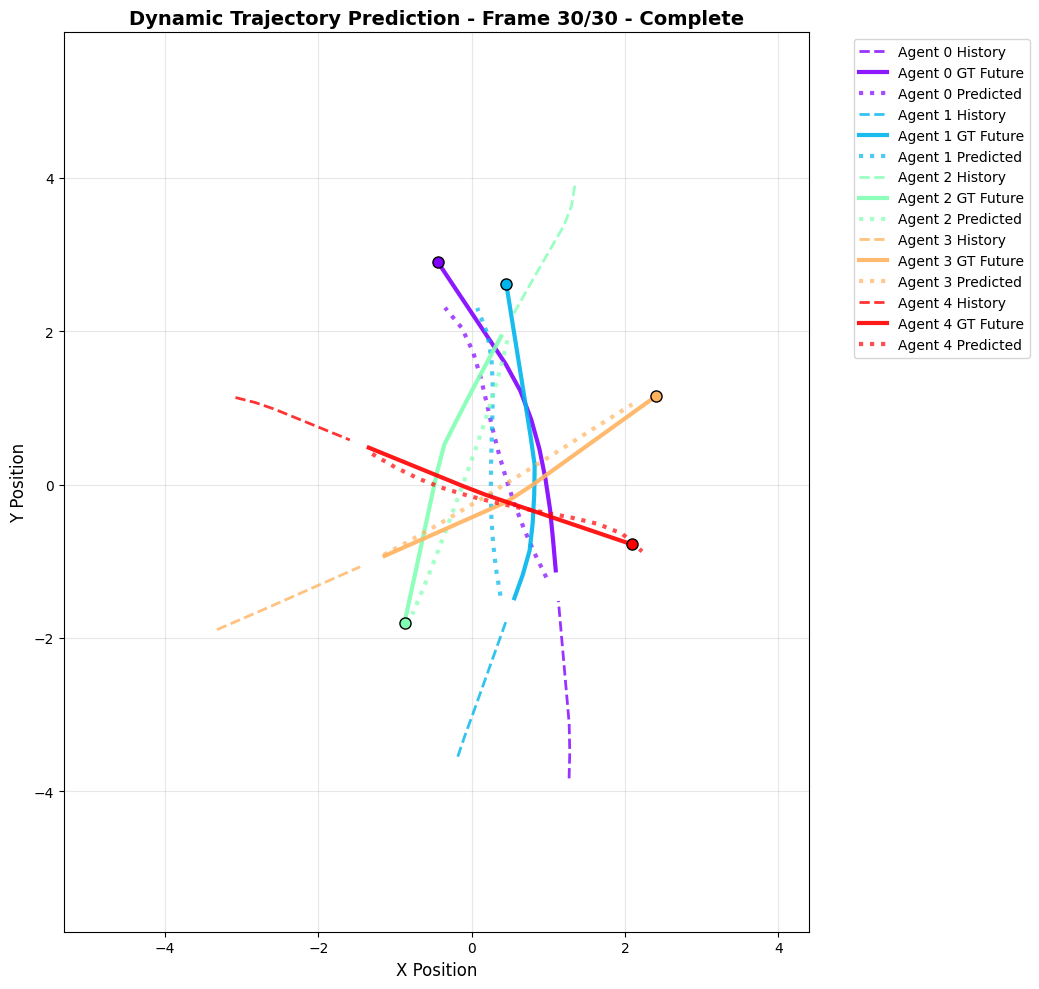

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import torch
import numpy as np

def visualize_trajectory_dynamic(history, future, prediction, save_gif=False, filename="trajectory_animation.gif"):
    """
    Dynamic visualization of trajectory prediction with animation

    Args:
        history: Historical trajectory data [num_agents, hist_len, 2]
        future: Ground truth future trajectory [num_agents, fut_len, 2]
        prediction: Predicted future trajectory [num_agents, fut_len, 2]
        save_gif: Whether to save animation as GIF
        filename: Name of the GIF file to save
    """
    num_agents = history.shape[0]
    hist_len = history.shape[1]
    fut_len = future.shape[1]

    # Convert to numpy if tensors
    if torch.is_tensor(history):
        history = history.cpu().numpy()
    if torch.is_tensor(future):
        future = future.cpu().numpy()
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = cm.rainbow(np.linspace(0, 1, num_agents))

    # Initialize empty line objects for each agent
    hist_lines = []
    fut_lines = []
    pred_lines = []
    current_pos_markers = []

    for i in range(num_agents):
        # History lines (dashed)
        hist_line, = ax.plot([], [], color=colors[i], linestyle='--',
                            linewidth=2, alpha=0.8, label=f'Agent {i} History')
        hist_lines.append(hist_line)

        # Future ground truth lines (solid)
        fut_line, = ax.plot([], [], color=colors[i], linestyle='-',
                           linewidth=3, alpha=0.9, label=f'Agent {i} GT Future')
        fut_lines.append(fut_line)

        # Predicted future lines (dotted)
        pred_line, = ax.plot([], [], color=colors[i], linestyle=':',
                            linewidth=3, alpha=0.7, label=f'Agent {i} Predicted')
        pred_lines.append(pred_line)

        # Current position markers
        marker, = ax.plot([], [], 'o', color=colors[i], markersize=8,
                         markeredgecolor='black', markeredgewidth=1)
        current_pos_markers.append(marker)

    # Set up the plot
    all_points = np.concatenate([history.reshape(-1, 2),
                                future.reshape(-1, 2),
                                prediction.reshape(-1, 2)], axis=0)

    # Filter out padding points for axis limits
    valid_mask = ~((all_points[:, 0] == 0) & (all_points[:, 1] == 0))
    if np.any(valid_mask):
        valid_points = all_points[valid_mask]
        margin = 2.0
        ax.set_xlim(valid_points[:, 0].min() - margin, valid_points[:, 0].max() + margin)
        ax.set_ylim(valid_points[:, 1].min() - margin, valid_points[:, 1].max() + margin)
    else:
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_title('Dynamic Trajectory Prediction Visualization', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Animation parameters
    total_frames = hist_len + fut_len + 10  # Extra frames to show final result

    def animate(frame):
        """Animation function called for each frame"""

        for i in range(num_agents):
            # Filter out padding points for this agent
            hist_mask = ~((history[i][:, 0] == 0) & (history[i][:, 1] == 0))
            fut_mask = ~((future[i][:, 0] == 0) & (future[i][:, 1] == 0))
            pred_mask = ~((prediction[i][:, 0] == 0) & (prediction[i][:, 1] == 0))

            hist_filtered = history[i][hist_mask]
            fut_filtered = future[i][fut_mask]
            pred_filtered = prediction[i][pred_mask]

            # Phase 1: Show history being drawn
            if frame < hist_len:
                if len(hist_filtered) > 0 and frame < len(hist_filtered):
                    end_idx = min(frame + 1, len(hist_filtered))
                    hist_lines[i].set_data(hist_filtered[:end_idx, 0], hist_filtered[:end_idx, 1])

                    # Show current position marker at the end of history
                    if end_idx > 0:
                        current_pos_markers[i].set_data([hist_filtered[end_idx-1, 0]],
                                                       [hist_filtered[end_idx-1, 1]])

            # Phase 2: Show future trajectories being drawn
            elif frame < hist_len + fut_len:
                # Keep full history visible
                if len(hist_filtered) > 0:
                    hist_lines[i].set_data(hist_filtered[:, 0], hist_filtered[:, 1])

                future_frame = frame - hist_len

                # Draw ground truth future progressively
                if len(fut_filtered) > 0 and future_frame < len(fut_filtered):
                    end_idx = min(future_frame + 1, len(fut_filtered))
                    fut_lines[i].set_data(fut_filtered[:end_idx, 0], fut_filtered[:end_idx, 1])

                # Draw predicted future progressively
                if len(pred_filtered) > 0 and future_frame < len(pred_filtered):
                    end_idx = min(future_frame + 1, len(pred_filtered))
                    pred_lines[i].set_data(pred_filtered[:end_idx, 0], pred_filtered[:end_idx, 1])

                # Update current position marker
                if len(fut_filtered) > 0 and future_frame < len(fut_filtered):
                    current_pos_markers[i].set_data([fut_filtered[future_frame, 0]],
                                                   [fut_filtered[future_frame, 1]])

            # Phase 3: Show complete trajectories
            else:
                if len(hist_filtered) > 0:
                    hist_lines[i].set_data(hist_filtered[:, 0], hist_filtered[:, 1])
                if len(fut_filtered) > 0:
                    fut_lines[i].set_data(fut_filtered[:, 0], fut_filtered[:, 1])
                if len(pred_filtered) > 0:
                    pred_lines[i].set_data(pred_filtered[:, 0], pred_filtered[:, 1])

                # Keep marker at final position
                if len(fut_filtered) > 0:
                    current_pos_markers[i].set_data([fut_filtered[-1, 0]], [fut_filtered[-1, 1]])

        # Update frame counter in title
        phase = "Drawing History" if frame < hist_len else "Drawing Future" if frame < hist_len + fut_len else "Complete"
        ax.set_title(f'Dynamic Trajectory Prediction - Frame {frame+1}/{total_frames} - {phase}',
                    fontsize=14, fontweight='bold')

        return hist_lines + fut_lines + pred_lines + current_pos_markers

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                 interval=200, blit=False, repeat=True)

    plt.tight_layout()

    # Save as GIF if requested
    if save_gif:
        print(f"Saving animation as {filename}...")
        anim.save(filename, writer='pillow', fps=5)
        print("Animation saved!")

    plt.show()
    return anim

def visualize_trajectory_interactive(history, future, prediction):
    """
    Interactive visualization with slider control
    """
    from matplotlib.widgets import Slider

    num_agents = history.shape[0]
    hist_len = history.shape[1]
    fut_len = future.shape[1]

    # Convert to numpy if tensors
    if torch.is_tensor(history):
        history = history.cpu().numpy()
    if torch.is_tensor(future):
        future = future.cpu().numpy()
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()

    # Create figure with slider
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.subplots_adjust(bottom=0.2)

    colors = cm.rainbow(np.linspace(0, 1, num_agents))

    # Create slider
    ax_slider = plt.axes([0.2, 0.05, 0.6, 0.03])
    slider = Slider(ax_slider, 'Time Step', 0, hist_len + fut_len - 1,
                   valinit=0, valfmt='%d')

    def update_plot(val):
        ax.clear()
        time_step = int(slider.val)

        for i in range(num_agents):
            # Filter out padding points
            hist_mask = ~((history[i][:, 0] == 0) & (history[i][:, 1] == 0))
            fut_mask = ~((future[i][:, 0] == 0) & (future[i][:, 1] == 0))
            pred_mask = ~((prediction[i][:, 0] == 0) & (prediction[i][:, 1] == 0))

            hist_filtered = history[i][hist_mask]
            fut_filtered = future[i][fut_mask]
            pred_filtered = prediction[i][pred_mask]

            # Show history up to current time
            if time_step < hist_len and len(hist_filtered) > 0:
                end_idx = min(time_step + 1, len(hist_filtered))
                if end_idx > 0:
                    ax.plot(hist_filtered[:end_idx, 0], hist_filtered[:end_idx, 1],
                           color=colors[i], linestyle='--', linewidth=2,
                           label=f'Agent {i} History')
                    ax.scatter(hist_filtered[end_idx-1, 0], hist_filtered[end_idx-1, 1],
                              color=colors[i], s=100, marker='o', edgecolor='black')

            # Show future trajectories
            elif time_step >= hist_len:
                # Show full history
                if len(hist_filtered) > 0:
                    ax.plot(hist_filtered[:, 0], hist_filtered[:, 1],
                           color=colors[i], linestyle='--', linewidth=2, alpha=0.7)

                future_step = time_step - hist_len

                # Show ground truth future up to current step
                if len(fut_filtered) > 0 and future_step < len(fut_filtered):
                    end_idx = future_step + 1
                    ax.plot(fut_filtered[:end_idx, 0], fut_filtered[:end_idx, 1],
                           color=colors[i], linestyle='-', linewidth=3,
                           label=f'Agent {i} GT Future')
                    ax.scatter(fut_filtered[future_step, 0], fut_filtered[future_step, 1],
                              color=colors[i], s=100, marker='o', edgecolor='black')

                # Show predicted future up to current step
                if len(pred_filtered) > 0 and future_step < len(pred_filtered):
                    end_idx = future_step + 1
                    ax.plot(pred_filtered[:end_idx, 0], pred_filtered[:end_idx, 1],
                           color=colors[i], linestyle=':', linewidth=3, alpha=0.8,
                           label=f'Agent {i} Predicted')

        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Interactive Trajectory Visualization - Time Step: {time_step}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_aspect('equal')

        # Set consistent axis limits
        all_points = np.concatenate([history.reshape(-1, 2),
                                    future.reshape(-1, 2),
                                    prediction.reshape(-1, 2)], axis=0)
        valid_mask = ~((all_points[:, 0] == 0) & (all_points[:, 1] == 0))
        if np.any(valid_mask):
            valid_points = all_points[valid_mask]
            margin = 2.0
            ax.set_xlim(valid_points[:, 0].min() - margin, valid_points[:, 0].max() + margin)
            ax.set_ylim(valid_points[:, 1].min() - margin, valid_points[:, 1].max() + margin)

        plt.draw()

    slider.on_changed(update_plot)
    update_plot(0)  # Initialize plot
    plt.show()

# Usage example with your existing code:
# Replace your visualization call with:

# === Run on one batch for illustration ===
with torch.no_grad():
    for history, future, neighbors, goals in dataloader:
        history = history.to(device)
        future = future.to(device)
        neighbors = neighbors.to(device)

        # Get model predictions (PFM-adjusted)
        prediction, coeff_mean, coeff_var = model(history, neighbors)

        print("Prediction shape:", prediction.shape)
        print(f"Coefficient mean: {coeff_mean:.4f}, variance: {coeff_var:.4f}")

        # Use dynamic visualization instead of static
        # Option 1: Animated visualization
        anim = visualize_trajectory_dynamic(history[0], future[0], prediction[0],
                                          save_gif=True, filename="trajectory_pred.gif")

        # Option 2: Interactive visualization with slider
        # visualize_trajectory_interactive(history[0], future[0], prediction[0])

        break



# Debugging

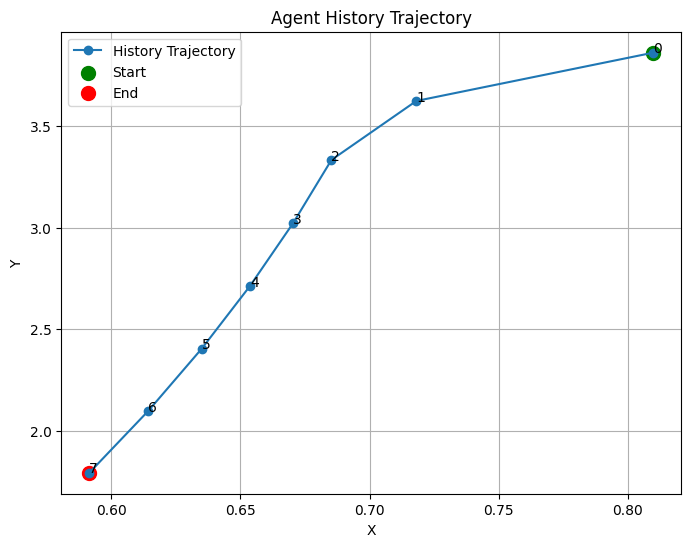

In [ ]:
# ===== TEST CASE 2: Inspect History Data Structure =====
import matplotlib.pyplot as plta
import numpy as np
import torch

def visualize_raw_trajectories(dataset, sample_idx=0):
    """Visualize raw trajectory data to identify issues"""
    print("\n=== Visualizing Raw History Trajectories ===")

    history, future, neighbors = dataset[sample_idx]
    num_agents = history.shape[0]
    print(f"Sample {sample_idx}: Number of agents = {num_agents}")
    print(f"History shape: {history.shape}")  # [num_agents, timesteps, 2]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Raw history trajectories
    for agent_idx in range(num_agents):
        agent_hist = history[agent_idx].numpy()
        print(f"\nAgent {agent_idx} history:\n{agent_hist}")

        valid_points = np.where((agent_hist != 0).any(axis=1))[0]
        print(f"Valid points (non-zero frames): {valid_points}")

        # Plot history trajectory points
        if len(valid_points) > 0:
            axs[0].scatter(agent_hist[valid_points, 0], agent_hist[valid_points, 1],
                           label=f"Agent {agent_idx}", alpha=0.7)

            # Connect valid adjacent points
            for i in range(len(valid_points) - 1):
                curr, next_ = valid_points[i], valid_points[i+1]
                if next_ - curr == 1:  # Only connect adjacent
                    axs[0].plot(
                        [agent_hist[curr, 0], agent_hist[next_, 0]],
                        [agent_hist[curr, 1], agent_hist[next_, 1]],
                        alpha=0.5
                    )

            # Mark start and end
            axs[0].scatter(agent_hist[valid_points[0], 0], agent_hist[valid_points[0], 1],
                          marker='o', s=100, facecolors='none', edgecolors='black')
            axs[0].scatter(agent_hist[valid_points[-1], 0], agent_hist[valid_points[-1], 1],
                          marker='x', s=100)

    axs[0].set_title("Raw History Data")
    axs[0].set_xlabel("X Position")
    axs[0].set_ylabel("Y Position")
    axs[0].grid(True)
    axs[0].legend()

    # Plot 2: Detailed agent trajectories with frame numbers
    for agent_idx in range(min(3, num_agents)):
        agent_hist = history[agent_idx].numpy()
        for t in range(agent_hist.shape[0]):
            if (agent_hist[t] != 0).any():
                axs[1].scatter(agent_hist[t, 0], agent_hist[t, 1], alpha=0.7)
                axs[1].annotate(f"{t}", (agent_hist[t, 0], agent_hist[t, 1]))
                if t > 0 and (agent_hist[t - 1] != 0).any():
                    axs[1].arrow(agent_hist[t - 1, 0], agent_hist[t - 1, 1],
                                 agent_hist[t, 0] - agent_hist[t - 1, 0],
                                 agent_hist[t, 1] - agent_hist[t - 1, 1],
                                 head_width=0.05, head_length=0.1,
                                 fc='black', ec='black', alpha=0.5)

    axs[1].set_title("Detailed View (Frame Numbers)")
    axs[1].set_xlabel("X Position")
    axs[1].set_ylabel("Y Position")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# visualize_raw_trajectories(dataset, sample_idx=0)

import numpy as np
import torch
from collections import defaultdict

def load_orca_dataset(file_path, history_frames=8, future_frames=12):
    valid_rows = []

    with open(file_path, "r") as f:
        for line_num, line in enumerate(f, start=1):
            parts = line.strip().split(",")
            if len(parts) != 4:
                continue  # Skip malformed lines
            try:
                frame_id = int(parts[0])
                agent_id = int(parts[1])
                x = float(parts[2])
                y = float(parts[3])
                valid_rows.append([frame_id, agent_id, x, y])
            except ValueError:
                continue  # Skip lines with non-numeric data

    data = np.array(valid_rows)

    trajectories = defaultdict(list)
    for frame_id, agent_id, x, y in data:
        trajectories[int(agent_id)].append((int(frame_id), float(x), float(y)))

    # Sort each agent's trajectory
    for aid in trajectories:
        trajectories[aid] = sorted(trajectories[aid], key=lambda x: x[0])

    dataset = []

    for agent_id, traj in trajectories.items():
        traj = np.array(traj)
        for i in range(history_frames, len(traj) - future_frames):
            hist = traj[i-history_frames:i, 1:3]
            fut = traj[i:i+future_frames, 1:3]
            dataset.append((
                torch.tensor(hist, dtype=torch.float32),
                torch.tensor(fut, dtype=torch.float32),
                None  # placeholder for neighbors if needed later
            ))

    return dataset

dataset_path = "/content/orca_circle_crossing_5ped_1000scenes_.txt"
parsed_dataset = load_orca_dataset(dataset_path)

# Plot 1 sample's history
def plot_parsed_histories(dataset, sample_idx=0):
    history, _, _ = dataset[sample_idx]
    history = history.numpy()

    plt.figure(figsize=(8, 6))
    plt.plot(history[:, 0], history[:, 1], marker='o', label="History Trajectory")
    plt.scatter(history[0, 0], history[0, 1], color='green', label="Start", s=100)
    plt.scatter(history[-1, 0], history[-1, 1], color='red', label="End", s=100)
    for i, (x, y) in enumerate(history):
        plt.annotate(str(i), (x, y))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Agent History Trajectory")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_parsed_histories(parsed_dataset, sample_idx=0)

# Testing on Datasets

In [ ]:
import pandas as pd
import numpy as np

# 1. PREPROCESS THE TEST DATASET

import pandas as pd
import numpy as np

def convert_and_clean_txt_for_pfm(txt_file, output_txt_file):
    df = pd.read_csv(txt_file, delim_whitespace=True, header=None, names=['frame', 'agent_id', 'x', 'y'])
    df.replace("?", np.nan, inplace=True)
    df.dropna(inplace=True)
    df['frame'] = df['frame'].astype(int)
    df['agent_id'] = df['agent_id'].astype(int)
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df.to_csv(output_txt_file, index=False, header=False)
    print(f"✅ Cleaned and saved formatted txt for PFM dataset: {output_txt_file}")

# Preprocess the raw test dataset
convert_and_clean_txt_for_pfm('/content/crowds_zara02_test.txt', '/content/crowds_zara02_test_cleaned.txt')


✅ Cleaned and saved formatted txt for PFM dataset: /content/crowds_zara02_test_cleaned.txt


/tmp/ipython-input-3111902022.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True, header=None, names=['frame', 'agent_id', 'x', 'y'])


In [ ]:
import torch.nn.functional as F

def compute_ADE(pred, gt):
    return F.mse_loss(pred, gt, reduction='none').sum(dim=2).sqrt().mean().item()

def compute_FDE(pred, gt):
    return F.mse_loss(pred[:, -1], gt[:, -1], reduction='none').sum(dim=1).sqrt().mean().item()

def compute_miss_rate(pred, gt, threshold=2.0):
    final_dist = F.mse_loss(pred[:, -1], gt[:, -1], reduction='none').sum(dim=1).sqrt()
    misses = (final_dist > threshold).float()
    return (misses.sum() / len(misses)).item()

In [ ]:
def test_with_metrics_pfm(model_path, cleaned_txt_file):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset = PFM_TrajectoryDataset(cleaned_txt_file)
    print(f"\n📦 Loaded {len(dataset)} frame samples for evaluation.")

    if len(dataset) == 0:
        print("❌ No valid samples available. Check your preprocessing.")
        return

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    model = IntegratedMTAPFMModel().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    total_ade, total_fde, total_miss = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for history, future, neighbors, goal in dataloader:
            history = history.to(device)
            future = future.to(device)
            neighbors = neighbors.to(device)
            goal = goal.to(device)

            pred, _, _ = model(history, neighbors, goal)  # [1, A, 12, 2]
            pred = pred[0]    # [A, 12, 2]
            future = future[0]  # [A, T, 2]

            # Fix length mismatch
            min_len = min(pred.size(1), future.size(1))
            if pred.size(1) != future.size(1):
                print(f"⚠️ Truncating: pred_len={pred.size(1)}, future_len={future.size(1)} → using {min_len}")
            pred = pred[:, :min_len, :]
            future = future[:, :min_len, :]

            ade = torch.norm(pred - future, dim=-1).mean().item()
            fde = torch.norm(pred[:, -1, :] - future[:, -1, :], dim=-1).mean().item()
            miss = (torch.norm(pred[:, -1, :] - future[:, -1, :], dim=-1) > 2.0).float().mean().item()

            total_ade += ade
            total_fde += fde
            total_miss += miss
            count += 1

    if count == 0:
        print("❌ Evaluation aborted: No samples processed.")
        return

    print(f"\n📊 Evaluation Metrics on Test Dataset:")
    print(f"🔹 Average ADE:  {total_ade / count:.4f}")
    print(f"🔹 Average FDE:  {total_fde / count:.4f}")
    print(f"🔹 Miss Rate:    {total_miss / count:.4f} (threshold: 2m)")

In [ ]:
def test_with_metrics_mta(model_path, cleaned_txt_file):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset = PFM_TrajectoryDataset(cleaned_txt_file)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    model = DeepLSTMModel().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])  # must match model architecture
    model.eval()

    total_ade, total_fde, total_miss = 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for history, future, neighbors, goal in dataloader:
            history = history.to(device)
            future = future.to(device)
            neighbors = neighbors.to(device)
            goal = goal.to(device)

            pred, _, _ = model(history, neighbors, goal)  # [1, A, 12, 2]
            pred = pred[0]    # [A, 12, 2]
            future = future[0]  # [A, T, 2]

            # Fix length mismatch
            min_len = min(pred.size(1), future.size(1))
            if pred.size(1) != future.size(1):
                print(f"⚠️ Truncating: pred_len={pred.size(1)}, future_len={future.size(1)} → using {min_len}")
            pred = pred[:, :min_len, :]
            future = future[:, :min_len, :]

            ade = torch.norm(pred - future, dim=-1).mean().item()
            fde = torch.norm(pred[:, -1, :] - future[:, -1, :], dim=-1).mean().item()
            miss = (torch.norm(pred[:, -1, :] - future[:, -1, :], dim=-1) > 2.0).float().mean().item()

            total_ade += ade
            total_fde += fde
            total_miss += miss
            count += 1

    if count == 0:
        print("❌ Evaluation aborted: No samples processed.")
        return

    print(f"\n📊 Evaluation Metrics on Test Dataset:")
    print(f"🔹 Average ADE:  {total_ade / count:.4f}")
    print(f"🔹 Average FDE:  {total_fde / count:.4f}")
    print(f"🔹 Miss Rate:    {total_miss / count:.4f} (threshold: 2m)")

In [ ]:

if __name__ == "__main__":
    # convert_and_clean_txt_for_pfm(
    #     '/content/orca_circle_crossing_5ped_1000scenes_.txt',
    #     '/content/orca_cleaned_circle_crossing_5ped_1000scenes_.txt'
    # )

    test_with_metrics_pfm(
        '/content/mta_pfm_trajectory_model_Zara.pth',
        '/content/crowds_zara02_test_cleaned.txt'
    )


📦 Loaded 1009 frame samples for evaluation.

📊 Evaluation Metrics on Test Dataset:
🔹 Average ADE:  3.9173
🔹 Average FDE:  6.5356
🔹 Miss Rate:    0.8313 (threshold: 2m)


In [ ]:

if __name__ == "__main__":
    # convert_and_clean_txt_for_pfm(
    #     '/content/orca_circle_crossing_5ped_1000scenes_.txt',
    #     '/content/orca_cleaned_circle_crossing_5ped_1000scenes_.txt'
    # )

    test_with_metrics_mta(
        '/content/mta_trajectory_model_Zara.pth',
        '/content/crowds_zara02_test_cleaned.txt'
    )


📦 Loaded 1009 frame samples for evaluation.


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Evaluation Metrics on Test Dataset:
🔹 Average ADE:  3.9409
🔹 Average FDE:  6.5373
🔹 Miss Rate:    0.8324 (threshold: 2m)


## Visualisation of test data

In [ ]:
import torch
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

# Assume model, dataset, and collate_fn are already defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load cleaned test dataset
dataset = PFM_TrajectoryDataset('/content/test_cleaned_crowds_zara01.txt')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Load your trained model
model = IntegratedMTAPFMModel().to(device)
checkpoint = torch.load('/content/mta_pfm_trajectory_model2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)  # Use strict=False if missing keys
model.eval()
# Place your dynamic and interactive visualization functions here from your previous example.

In [ ]:
# --- PASTE VISUALIZATION FUNCTIONS FROM YOUR EXAMPLE HERE ---
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import numpy as np
import torch

def visualize_trajectory_dynamic(history, future, prediction, save_gif=False, filename="trajectory_animation.gif"):
    """
    Dynamic visualization of trajectory prediction with animation

    Args:
        history: [num_agents, hist_len, 2]
        future: [num_agents, fut_len, 2]
        prediction: [num_agents, fut_len, 2]
        save_gif: Whether to save animation as GIF
        filename: Name of the GIF file to save
    """
    num_agents = history.shape[0]
    hist_len = history.shape[1]
    fut_len = future.shape[1]

    # Convert to numpy if tensors
    if torch.is_tensor(history):
        history = history.cpu().numpy()
    if torch.is_tensor(future):
        future = future.cpu().numpy()
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(12, 10))
    colors = cm.rainbow(np.linspace(0, 1, num_agents))

    hist_lines, fut_lines, pred_lines, current_pos_markers = [], [], [], []

    for i in range(num_agents):
        hist_line, = ax.plot([], [], color=colors[i], linestyle='--', linewidth=2, alpha=0.8, label=f'Agent {i} History')
        fut_line, = ax.plot([], [], color=colors[i], linestyle='-', linewidth=3, alpha=0.9, label=f'Agent {i} GT Future')
        pred_line, = ax.plot([], [], color=colors[i], linestyle=':', linewidth=3, alpha=0.7, label=f'Agent {i} Predicted')
        marker, = ax.plot([], [], 'o', color=colors[i], markersize=8, markeredgecolor='black', markeredgewidth=1)
        hist_lines.append(hist_line)
        fut_lines.append(fut_line)
        pred_lines.append(pred_line)
        current_pos_markers.append(marker)

    all_points = np.concatenate([history.reshape(-1, 2), future.reshape(-1, 2), prediction.reshape(-1, 2)], axis=0)
    valid_mask = ~((all_points[:, 0] == 0) & (all_points[:, 1] == 0))
    if np.any(valid_mask):
        valid_points = all_points[valid_mask]
        margin = 2.0
        ax.set_xlim(valid_points[:, 0].min() - margin, valid_points[:, 0].max() + margin)
        ax.set_ylim(valid_points[:, 1].min() - margin, valid_points[:, 1].max() + margin)
    else:
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)

    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_title('Dynamic Trajectory Prediction Visualization', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    total_frames = hist_len + fut_len + 10  # Extra frames

    def animate(frame):
        for i in range(num_agents):
            hist_mask = ~((history[i][:, 0] == 0) & (history[i][:, 1] == 0))
            fut_mask = ~((future[i][:, 0] == 0) & (future[i][:, 1] == 0))
            pred_mask = ~((prediction[i][:, 0] == 0) & (prediction[i][:, 1] == 0))

            hist_filtered = history[i][hist_mask]
            fut_filtered = future[i][fut_mask]
            pred_filtered = prediction[i][pred_mask]

            if frame < hist_len:
                if len(hist_filtered) > 0 and frame < len(hist_filtered):
                    end_idx = min(frame + 1, len(hist_filtered))
                    hist_lines[i].set_data(hist_filtered[:end_idx, 0], hist_filtered[:end_idx, 1])
                    if end_idx > 0:
                        current_pos_markers[i].set_data([hist_filtered[end_idx-1, 0]], [hist_filtered[end_idx-1, 1]])
            elif frame < hist_len + fut_len:
                if len(hist_filtered) > 0:
                    hist_lines[i].set_data(hist_filtered[:, 0], hist_filtered[:, 1])
                future_frame = frame - hist_len
                if len(fut_filtered) > 0 and future_frame < len(fut_filtered):
                    end_idx = min(future_frame + 1, len(fut_filtered))
                    fut_lines[i].set_data(fut_filtered[:end_idx, 0], fut_filtered[:end_idx, 1])
                if len(pred_filtered) > 0 and future_frame < len(pred_filtered):
                    end_idx = min(future_frame + 1, len(pred_filtered))
                    pred_lines[i].set_data(pred_filtered[:end_idx, 0], pred_filtered[:end_idx, 1])
                if len(fut_filtered) > 0 and future_frame < len(fut_filtered):
                    current_pos_markers[i].set_data([fut_filtered[future_frame, 0]], [fut_filtered[future_frame, 1]])
            else:
                if len(hist_filtered) > 0:
                    hist_lines[i].set_data(hist_filtered[:, 0], hist_filtered[:, 1])
                if len(fut_filtered) > 0:
                    fut_lines[i].set_data(fut_filtered[:, 0], fut_filtered[:, 1])
                if len(pred_filtered) > 0:
                    pred_lines[i].set_data(pred_filtered[:, 0], pred_filtered[:, 1])
                if len(fut_filtered) > 0:
                    current_pos_markers[i].set_data([fut_filtered[-1, 0]], [fut_filtered[-1, 1]])

        phase = "Drawing History" if frame < hist_len else "Drawing Future" if frame < hist_len + fut_len else "Complete"
        ax.set_title(f'Dynamic Trajectory Prediction - Frame {frame+1}/{total_frames} - {phase}',
                     fontsize=14, fontweight='bold')
        return hist_lines + fut_lines + pred_lines + current_pos_markers

    anim = animation.FuncAnimation(fig, animate, frames=total_frames,
                                   interval=200, blit=False, repeat=True)
    plt.tight_layout()

    if save_gif:
        print(f"Saving animation as {filename}...")
        anim.save(filename, writer='pillow', fps=5)
        print("Animation saved!")

    plt.show()
    return anim

def visualize_trajectory_interactive(history, future, prediction):
    """
    Interactive visualization with slider control.
    """
    from matplotlib.widgets import Slider

    num_agents = history.shape[0]
    hist_len = history.shape[1]
    fut_len = future.shape[1]

    if torch.is_tensor(history):
        history = history.cpu().numpy()
    if torch.is_tensor(future):
        future = future.cpu().numpy()
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.subplots_adjust(bottom=0.2)
    colors = cm.rainbow(np.linspace(0, 1, num_agents))
    ax_slider = plt.axes([0.2, 0.05, 0.6, 0.03])
    slider = Slider(ax_slider, 'Time Step', 0, hist_len + fut_len - 1, valinit=0, valfmt='%d')

    def update_plot(val):
        ax.clear()
        time_step = int(slider.val)
        for i in range(num_agents):
            hist_mask = ~((history[i][:, 0] == 0) & (history[i][:, 1] == 0))
            fut_mask = ~((future[i][:, 0] == 0) & (future[i][:, 1] == 0))
            pred_mask = ~((prediction[i][:, 0] == 0) & (prediction[i][:, 1] == 0))

            hist_filtered = history[i][hist_mask]
            fut_filtered = future[i][fut_mask]
            pred_filtered = prediction[i][pred_mask]

            if time_step < hist_len and len(hist_filtered) > 0:
                end_idx = min(time_step + 1, len(hist_filtered))
                if end_idx > 0:
                    ax.plot(hist_filtered[:end_idx, 0], hist_filtered[:end_idx, 1],
                            color=colors[i], linestyle='--', linewidth=2,
                            label=f'Agent {i} History')
                    ax.scatter(hist_filtered[end_idx-1, 0], hist_filtered[end_idx-1, 1],
                               color=colors[i], s=100, marker='o', edgecolor='black')
            elif time_step >= hist_len:
                if len(hist_filtered) > 0:
                    ax.plot(hist_filtered[:, 0], hist_filtered[:, 1],
                            color=colors[i], linestyle='--', linewidth=2, alpha=0.7)
                future_step = time_step - hist_len
                if len(fut_filtered) > 0 and future_step < len(fut_filtered):
                    end_idx = future_step + 1
                    ax.plot(fut_filtered[:end_idx, 0], fut_filtered[:end_idx, 1],
                            color=colors[i], linestyle='-', linewidth=3,
                            label=f'Agent {i} GT Future')
                    ax.scatter(fut_filtered[future_step, 0], fut_filtered[future_step, 1],
                               color=colors[i], s=100, marker='o', edgecolor='black')
                if len(pred_filtered) > 0 and future_step < len(pred_filtered):
                    end_idx = future_step + 1
                    ax.plot(pred_filtered[:end_idx, 0], pred_filtered[:end_idx, 1],
                            color=colors[i], linestyle=':', linewidth=3, alpha=0.8,
                            label=f'Agent {i} Predicted')

        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Interactive Trajectory Visualization - Time Step: {time_step}')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_aspect('equal')
        all_points = np.concatenate([history.reshape(-1, 2),
                                     future.reshape(-1, 2),
                                     prediction.reshape(-1, 2)], axis=0)
        valid_mask = ~((all_points[:, 0] == 0) & (all_points[:, 1] == 0))
        if np.any(valid_mask):
            valid_points = all_points[valid_mask]
            margin = 2.0
            ax.set_xlim(valid_points[:, 0].min() - margin, valid_points[:, 0].max() + margin)
            ax.set_ylim(valid_points[:, 1].min() - margin, valid_points[:, 1].max() + margin)
        plt.draw()

    slider.on_changed(update_plot)
    update_plot(0)
    plt.show()

In [ ]:
# 1. PREPROCESS THE TEST DATASET

import pandas as pd
import numpy as np

def convert_and_clean_txt_for_pfm(txt_file, output_txt_file):
    df = pd.read_csv(txt_file, delim_whitespace=True, header=None, names=['frame', 'agent_id', 'x', 'y'])
    df.replace("?", np.nan, inplace=True)
    df.dropna(inplace=True)
    df['frame'] = df['frame'].astype(int)
    df['agent_id'] = df['agent_id'].astype(int)
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df.to_csv(output_txt_file, index=False, header=False)
    print(f"✅ Cleaned and saved formatted txt for PFM dataset: {output_txt_file}")

# Preprocess the raw test dataset
convert_and_clean_txt_for_pfm('/content/test_crowds_zara01.txt', '/content/test_cleaned_crowds_zara01.txt')

✅ Cleaned and saved formatted txt for PFM dataset: /content/test_cleaned_crowds_zara01.txt


/tmp/ipython-input-2998954722.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True, header=None, names=['frame', 'agent_id', 'x', 'y'])


# Own data testing

In [ ]:
import json

def parse_json(filepath):
    with open(filepath) as f:
        data = json.load(f)
    entries = []
    for item in data["items"]:
        frame_str = item["frame"]  # "frame_0.jpg"
        frame_num = int(frame_str.split("_")[1].split(".")[0])
        for ann in item["annotations"]:
            agent_id = ann["attributes"]["track_id"]
            bbox = ann["bbox"]
            x = bbox[0] + bbox[2]/2
            y = bbox[1] + bbox[3]/2
            entries.append({'frame': frame_num, 'agent_id': agent_id, 'x': x, 'y': y})
    return entries

# Parse first file
entries1 = parse_json('/content/selected_annotations.json')
last_frame = max(e['frame'] for e in entries1)

# Parse second file -- with frame offset!
entries2 = parse_json('/content/selected_annotations(1).json')
min_frame2 = min(e['frame'] for e in entries2)
for e in entries2:
    e['frame'] = e['frame'] - min_frame2 + last_frame + 1  # offset frames

all_entries = entries1 + entries2

# Write output
with open('combined_annotations.csv', 'w') as f_out:
    for e in all_entries:
        f_out.write(f"{e['frame']},{e['agent_id']},{e['x']},{e['y']}\n")

In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.autograd.set_detect_anomaly(True)

    dataset = PFM_TrajectoryDataset('/content/orca_circle_crossing_5ped_1000scenes_.txt')
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    model = IntegratedMTAPFMModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)
    criterion = nn.MSELoss()

    print(f"🎯 Speed Constraints Enabled:")
    print(f"   Target Average Speed: {model.target_avg_speed:.4f}")
    print(f"   Allowed Range: [{model.min_speed:.4f}, {model.max_speed:.4f}]")
    print(f"   Tolerance: ±{model.speed_tolerance*100}%\n")

    for epoch in range(3):
        model.train()
        epoch_loss = 0.0

        # Speed tracking variables
        epoch_gt_speeds = []
        epoch_pred_speeds = []
        epoch_hist_speeds = []
        epoch_violations = []

        for batch_idx, (history, future, neighbors, goal) in enumerate(dataloader):
            history = history.clone().to(device)
            future = future.clone().to(device)
            neighbors = neighbors.clone().to(device)

            # RK: derive goal from final timestep of ground truth
            goal = future[:, :, -1, :].clone()  # shape: [B, A, 2]

            optimizer.zero_grad()
            pred, coeff_mean, coeff_var = model(history, neighbors, goal)  # RK: add goal

            loss = criterion(pred, future)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

            # Speed tracking
            with torch.no_grad():
                gt_speed = calculate_speed(future)
                pred_speed = calculate_speed(pred)
                hist_speed = calculate_speed(history)

                epoch_gt_speeds.append(gt_speed.item())
                epoch_pred_speeds.append(pred_speed.item())
                epoch_hist_speeds.append(hist_speed.item())

                violation_count = check_speed_violations(pred, history, model.min_speed, model.max_speed)
                epoch_violations.append(violation_count)

            if batch_idx % 50 == 0:
                k_att1_mean = coeff_mean.item()
                k_att1_var = coeff_var.item()

                print(f"[{batch_idx}] Loss: {loss:.4f} | k_att1 μ={k_att1_mean:.2f}, σ²={k_att1_var:.2f}")
                print(f"    Speeds - GT: {gt_speed:.3f}, Pred: {pred_speed:.3f}, Hist: {hist_speed:.3f}")
                print(f"    Speed Violations: {violation_count}")

        # Epoch summary
        avg_gt_speed = sum(epoch_gt_speeds) / len(epoch_gt_speeds)
        avg_pred_speed = sum(epoch_pred_speeds) / len(epoch_pred_speeds)
        avg_hist_speed = sum(epoch_hist_speeds) / len(epoch_hist_speeds)
        total_violations = sum(epoch_violations)

        print(f"\n=== EPOCH {epoch+1} SUMMARY ===")
        print(f"Avg Loss: {epoch_loss/len(dataloader):.4f}")
        print(f"Average Speeds:")
        print(f"  Historical: {avg_hist_speed:.4f}")
        print(f"  Ground Truth: {avg_gt_speed:.4f}")
        print(f"  Predicted: {avg_pred_speed:.4f} (Target: {model.target_avg_speed:.4f})")
        print(f"  Speed Error: {abs(avg_gt_speed - avg_pred_speed):.4f}")
        print(f"Speed Constraint Violations: {total_violations}")
        print(f"Constraint Compliance: {(1 - total_violations/(len(dataloader)*32*5*12))*100:.2f}%")
        print("=" * 40)

    torch.autograd.set_detect_anomaly(False)

    print("\n💾 Saving model...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': epoch_loss/len(dataloader),
        'speed_constraints': {
            'target_avg_speed': model.target_avg_speed,
            'min_speed': model.min_speed,
            'max_speed': model.max_speed,
            'tolerance': model.speed_tolerance
        },
        'final_avg_speeds': {
            'historical': avg_hist_speed,
            'ground_truth': avg_gt_speed,
            'predicted': avg_pred_speed
        }
    }, 'mta_pfm_trajectory_model2.pth')

    print("✅ Model saved with speed constraints!")



if __name__ == "__main__":
    main()